In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [ ]:
#present working directory
os.getcwd()

'/content'

In [ ]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize([imsize, imsize]),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("/content/drive/MyDrive/dl_test/picasso.jpg")
content_img = image_loader("/content/drive/MyDrive/dl_test/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
def imshow(tensor, title=None):
    """
    Helper function to display a tensor as an image.

    Args:
        tensor: PyTorch tensor of shape (3, H, W)
        title: Optional title for the plot
    """
    # Clone the tensor and detach it from the computation graph
    image = tensor.clone().detach().cpu()

    # Remove the batch dimension if present
    if image.dim() == 4:
        image = image.squeeze(0)

    # Convert to numpy array and transpose dimensions to (H, W, C)
    image = image.numpy().transpose(1, 2, 0)

    # Unnormalize if the image was normalized
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip values to be between 0 and 1
    image = np.clip(image, 0, 1)

    # Clear the current figure
    plt.clf()

    # Display the image
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Hide axes
    plt.tight_layout()  # Adjust the layout
    plt.draw()
    plt.pause(0.001)  # pause a bit so that plots are updated

# When displaying the output image, make sure to use this updated function
def save_and_display_result(output_tensor, filename='styled_image.png'):
    """
    Save and display the result of style transfer
    """
    plt.figure(figsize=(10, 10))
    imshow(output_tensor, title='Styled Image')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.show()

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 63.6MB/s]


In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

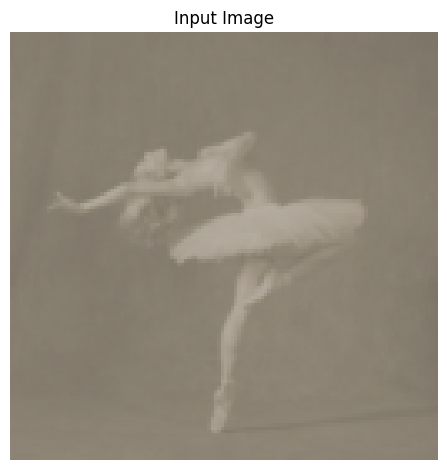

In [ ]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# .. code-block:: python
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=1000,
                       style_weight=10000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [ ]:
style_img = image_loader("/content/drive/MyDrive/dl_test/picasso.jpg")
content_img = image_loader("/content/drive/MyDrive/dl_test/koala.jpg")
print(style_img.size(), content_img.size())
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])


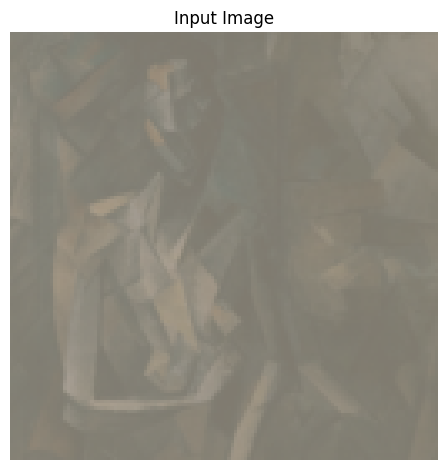

In [ ]:
imshow(style_img, title='Input Image')

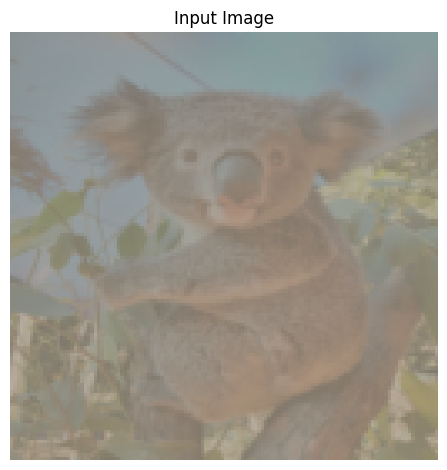

In [ ]:
imshow(content_img, title='Input Image')

Building the style transfer model..


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 1.811928 Content Loss: 8.203600

run [100]:
Style Loss : 1.658312 Content Loss: 5.869951

run [150]:
Style Loss : 1.617511 Content Loss: 5.419914

run [200]:
Style Loss : 1.614648 Content Loss: 5.270599

run [250]:
Style Loss : 1.617318 Content Loss: 5.178085

run [300]:
Style Loss : 1.616114 Content Loss: 5.111972

run [350]:
Style Loss : 1.618314 Content Loss: 5.063266

run [400]:
Style Loss : 1.617440 Content Loss: 5.028061

run [450]:
Style Loss : 1.613039 Content Loss: 5.004463

run [500]:
Style Loss : 1.613675 Content Loss: 4.981379

run [550]:
Style Loss : 1.610630 Content Loss: 4.965844

run [600]:
Style Loss : 1.604843 Content Loss: 4.954594

run [650]:
Style Loss : 1.598703 Content Loss: 4.947041

run [700]:
Style Loss : 1.596020 Content Loss: 4.937119

run [750]:
Style Loss : 1.588333 Content Loss: 4.937518

run [800]:
Style Loss : 1.584940 Content Loss: 4.930517

run [850]:
Style Loss : 1.580732 Content Loss: 4.930541

run [900]:
Style Lo

<Figure size 640x480 with 0 Axes>

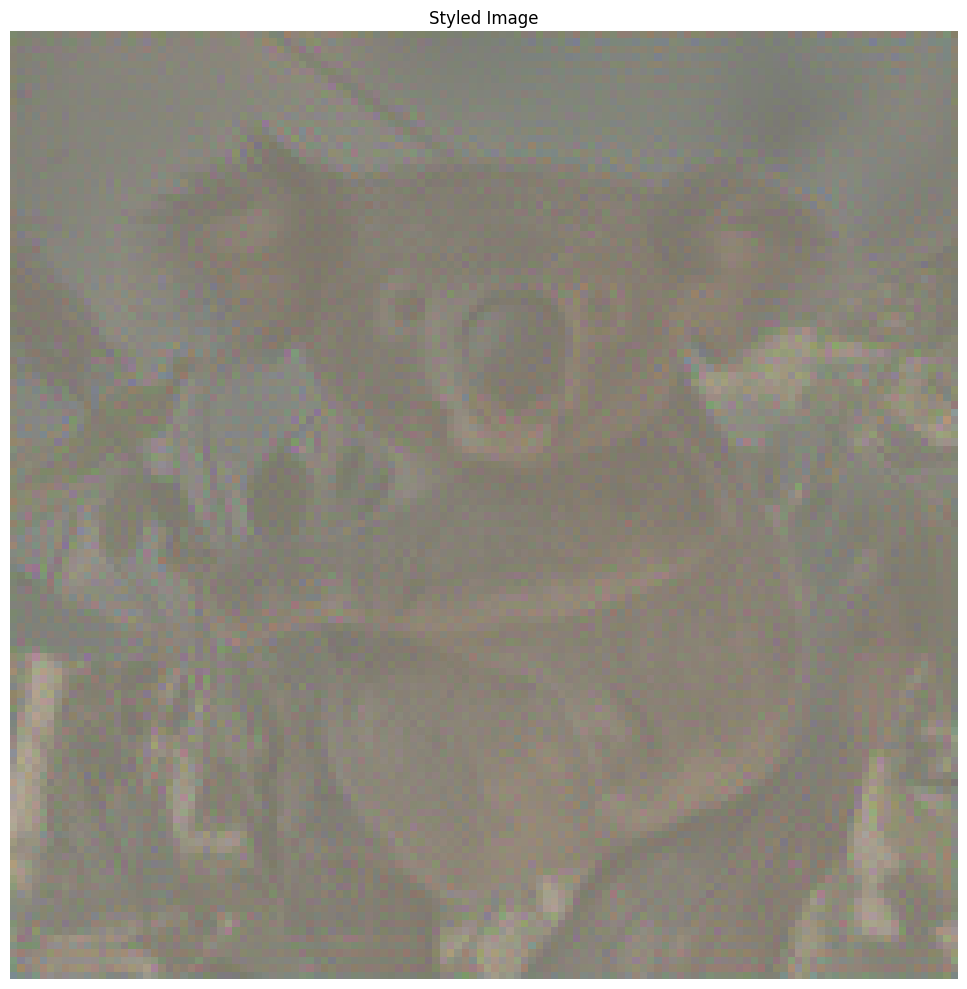

<Figure size 640x480 with 0 Axes>

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
save_and_display_result(output, "output.png")

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
from PIL import Image
import numpy as np

class StyleTransfer:
    def __init__(self, content_img_path, style_img_path, device=None):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.imsize = 512 if torch.cuda.is_available() else 256

        self.loader = transforms.Compose([
            transforms.Resize((self.imsize, self.imsize)),
            transforms.ToTensor(),
        ])

        self.content_img = self.image_loader(content_img_path)
        self.style_img = self.image_loader(style_img_path)

        self.cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval().to(self.device)
        for param in self.cnn.parameters():
            param.requires_grad = False

        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(self.device)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(self.device)

    def image_loader(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image = self.loader(image).unsqueeze(0).to(self.device)
        return image

    def gram_matrix(self, input):
        b, c, h, w = input.size()
        features = input.view(b * c, h * w)
        G = torch.mm(features, features.t())
        return G.div(c * h * w)

    def normalize(self, img):
        return (img - self.mean) / self.std

    def denormalize(self, img):
        return img * self.std + self.mean

    def get_features(self, x, layers):
        features = {}
        x = self.normalize(x)

        layer_mapping = {
            'conv1_1': '0',
            'conv2_1': '5',
            'conv3_1': '10',
            'conv4_1': '19',
            'conv4_2': '21',
            'conv5_1': '28'
        }

        current_layer = 0
        x = x.clone()

        for name, module in self.cnn._modules.items():
            x = module(x)
            if name in [layer_mapping[layer] for layer in layers]:
                for layer_name, idx in layer_mapping.items():
                    if name == idx:
                        features[layer_name] = x.clone()

        return features

    def run_style_transfer(self, num_steps=500, style_weight=1e5, content_weight=1):
        print('Starting style transfer...')

        content_layers = ['conv4_2']
        style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
        all_layers = content_layers + style_layers

        content_features = self.get_features(self.content_img, all_layers)
        style_features = self.get_features(self.style_img, all_layers)

        style_grams = {
            layer: self.gram_matrix(style_features[layer])
            for layer in style_layers
        }

        input_img = self.content_img.clone()
        input_img.requires_grad_(True)

        # Create optimizer with a smaller max_iter
        optimizer = optim.LBFGS([input_img], max_iter=1)

        step = [0]
        max_steps = num_steps

        while step[0] < max_steps:
            def closure():
                optimizer.zero_grad()
                current_features = self.get_features(input_img, all_layers)

                content_loss = 0
                for layer in content_layers:
                    content_loss += F.mse_loss(
                        current_features[layer],
                        content_features[layer]
                    )

                style_loss = 0
                style_layer_weights = [0.2, 0.2, 0.2, 0.2, 0.2]
                for layer, weight in zip(style_layers, style_layer_weights):
                    current_gram = self.gram_matrix(current_features[layer])
                    style_loss += weight * F.mse_loss(
                        current_gram,
                        style_grams[layer]
                    )

                loss = content_weight * content_loss + style_weight * style_loss
                loss.backward()

                if step[0] % 50 == 0:
                    print(f'Step {step[0]}/{max_steps}:')
                    print(f'Style Loss: {style_loss.item():.4f}')
                    print(f'Content Loss: {content_loss.item():.4f}')
                    print(f'Total Loss: {loss.item():.4f}\n')

                return loss

            optimizer.step(closure)

            # Clamp values
            with torch.no_grad():
                input_img.data.clamp_(0, 1)

            step[0] += 1

        return input_img

    def save_image(self, tensor, filename):
        image = tensor.cpu().clone()
        image = image.squeeze(0)
        transforms.ToPILImage()(image).save(filename)

def run_transfer(content_path, style_path, output_path,
                num_steps=500, style_weight=1e5, content_weight=1):
    torch.autograd.set_detect_anomaly(True)

    try:
        transfer = StyleTransfer(content_path, style_path)
        print("Model initialized successfully")

        output = transfer.run_style_transfer(
            num_steps=num_steps,
            style_weight=style_weight,
            content_weight=content_weight
        )
        print("Style transfer completed")

        transfer.save_image(output.detach(), output_path)
        print(f"Image saved to {output_path}")
        return output

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

In [ ]:
output = run_transfer(
    content_path="/content/drive/MyDrive/dl_test/groundtruth.jpeg",
    style_path="/content/drive/MyDrive/dl_test/universe.jpg",
    output_path="output.png",
    num_steps=1000,
    style_weight=1e9,  # Reduced style weight
    content_weight=10000
)

Model initialized successfully
Starting style transfer...
Step 0/1000:
Style Loss: 0.0100
Content Loss: 0.0000
Total Loss: 10008181.0000

Step 50/1000:
Style Loss: 0.0002
Content Loss: 48.3618
Total Loss: 674240.0625

Step 100/1000:
Style Loss: 0.0001
Content Loss: 41.9705
Total Loss: 564380.8750

Step 150/1000:
Style Loss: 0.0001
Content Loss: 39.8146
Total Loss: 531793.6875

Step 200/1000:
Style Loss: 0.0001
Content Loss: 38.6768
Total Loss: 517120.7500

Step 250/1000:
Style Loss: 0.0001
Content Loss: 38.0627
Total Loss: 508838.7812

Step 300/1000:
Style Loss: 0.0001
Content Loss: 37.6474
Total Loss: 503574.4062

Step 350/1000:
Style Loss: 0.0001
Content Loss: 37.3187
Total Loss: 499813.2812

Step 400/1000:
Style Loss: 0.0001
Content Loss: 37.0980
Total Loss: 496822.5625

Step 450/1000:
Style Loss: 0.0001
Content Loss: 36.8820
Total Loss: 495015.0625

Step 500/1000:
Style Loss: 0.0001
Content Loss: 36.7705
Total Loss: 492516.5625

Step 550/1000:
Style Loss: 0.0001
Content Loss: 36.62

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
from PIL import Image
import numpy as np

class RobustMaskedStyleTransfer:
    def __init__(self, content_img_path, style_img_path, device=None, mask_threshold=0.1):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.imsize = 512 if torch.cuda.is_available() else 256

        self.loader = transforms.Compose([
            transforms.Resize((self.imsize, self.imsize)),
            transforms.ToTensor(),
        ])

        # Load images
        self.content_img = self.image_loader(content_img_path)
        self.style_img = self.image_loader(style_img_path)

        # Create binary mask from content image
        luminance = 0.299 * self.content_img[:, 0] + 0.587 * self.content_img[:, 1] + 0.114 * self.content_img[:, 2]
        self.mask = (luminance > mask_threshold).float().unsqueeze(1)

        # Ensure mask has some valid pixels
        if self.mask.sum() < 1:
            raise ValueError("Mask is empty! Adjust threshold or check content image.")

        print(f"Mask contains {self.mask.sum().item():.0f} active pixels")

        # Load VGG model
        self.cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval().to(self.device)
        for param in self.cnn.parameters():
            param.requires_grad = False

        # Normalization constants
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(self.device)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(self.device)

    def image_loader(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image = self.loader(image).unsqueeze(0).to(self.device)
        return image

    def gram_matrix(self, input_tensor, mask=None):
        """
        Compute gram matrix with careful handling of masked regions and numerical stability
        """
        b, c, h, w = input_tensor.size()

        if mask is not None:
            # Resize mask if needed
            if mask.size()[-2:] != input_tensor.size()[-2:]:
                mask = F.interpolate(mask, size=input_tensor.size()[-2:], mode='nearest')

            # Apply mask and handle empty masks
            masked_input = input_tensor * mask
            num_locations = mask.sum() + 1e-8  # Add small epsilon to prevent division by zero

            # Reshape and compute gram matrix
            features = masked_input.view(b * c, -1)
            G = torch.mm(features, features.t())

            # Normalize by number of active elements in mask
            return G.div(num_locations)
        else:
            features = input_tensor.view(b * c, -1)
            G = torch.mm(features, features.t())
            return G.div(c * h * w)

    def normalize(self, img):
        return (img - self.mean) / self.std

    def denormalize(self, img):
        return img * self.std + self.mean

    def get_features(self, x, layers):
        features = {}
        x = self.normalize(x.clone())

        layer_mapping = {
            'conv1_1': '0',
            'conv2_1': '5',
            'conv3_1': '10',
            'conv4_1': '19',
            'conv4_2': '21',
            'conv5_1': '28'
        }

        for name, module in self.cnn._modules.items():
            x = module(x)
            if name in [layer_mapping[layer] for layer in layers]:
                for layer_name, idx in layer_mapping.items():
                    if name == idx:
                        features[layer_name] = x.clone()

        return features

    def run_style_transfer(self, num_steps=500, style_weight=1e6, content_weight=1, tv_weight=1e-6):
        print('Starting robust masked style transfer...')

        content_layers = ['conv4_2']
        style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
        all_layers = content_layers + style_layers

        # Get features
        content_features = self.get_features(self.content_img, all_layers)
        style_features = self.get_features(self.style_img, all_layers)

        # Compute style gram matrices
        style_grams = {
            layer: self.gram_matrix(style_features[layer])
            for layer in style_layers
        }

        # Initialize input image
        input_img = self.content_img.clone()
        input_img.requires_grad_(True)

        # Use Adam optimizer instead of LBFGS for better stability
        optimizer = optim.Adam([input_img], lr=0.01)

        best_loss = float('inf')
        best_img = None

        for step in range(num_steps):
            def get_loss():
                # Clear gradients
                optimizer.zero_grad()

                # Get current features
                current_features = self.get_features(input_img, all_layers)

                # Content loss
                content_loss = 0
                for layer in content_layers:
                    current_mask = F.interpolate(self.mask, size=current_features[layer].size()[-2:], mode='nearest')
                    masked_current = current_features[layer] * current_mask
                    masked_content = content_features[layer] * current_mask
                    content_loss += F.mse_loss(masked_current, masked_content)

                # Style loss with stability checks
                style_loss = 0
                style_layer_weights = [1.0, 0.8, 0.6, 0.4, 0.2]
                for layer, weight in zip(style_layers, style_layer_weights):
                    current_mask = F.interpolate(self.mask, size=current_features[layer].size()[-2:], mode='nearest')

                    # Compute gram matrices
                    current_gram = self.gram_matrix(current_features[layer], current_mask)

                    # Check for invalid values
                    if torch.isnan(current_gram).any() or torch.isinf(current_gram).any():
                        print(f"Warning: Invalid values in gram matrix at layer {layer}")
                        continue

                    layer_style_loss = weight * F.mse_loss(current_gram, style_grams[layer])
                    style_loss += layer_style_loss

                # Total variation regularization for smoothness
                tv_loss = tv_weight * (
                    torch.sum(torch.abs(input_img[:, :, :, :-1] - input_img[:, :, :, 1:])) +
                    torch.sum(torch.abs(input_img[:, :, :-1, :] - input_img[:, :, 1:, :]))
                )

                # Total loss
                total_loss = content_weight * content_loss + style_weight * style_loss + tv_loss

                return total_loss, content_loss, style_loss, tv_loss

            # Compute loss
            total_loss, content_loss, style_loss, tv_loss = get_loss()

            # Check for invalid loss
            if torch.isnan(total_loss) or torch.isinf(total_loss):
                print(f"Warning: Invalid loss at step {step}, skipping...")
                continue

            # Backward pass
            total_loss.backward()

            # Update image
            optimizer.step()

            # Clamp values while preserving original black pixels
            with torch.no_grad():
                # Clamp only the masked regions
                input_img.data = (
                    self.content_img * (1 - self.mask) +
                    (input_img.data.clamp(0, 1) * self.mask)
                )

            # Save best result
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                best_img = input_img.clone()

            # Print progress
            if step % 50 == 0:
                print(f'Step {step}/{num_steps}:')
                print(f'Content Loss: {content_loss.item():.4f}')
                print(f'Style Loss: {style_loss.item():.4f}')
                print(f'TV Loss: {tv_loss.item():.4f}')
                print(f'Total Loss: {total_loss.item():.4f}\n')

        return best_img if best_img is not None else input_img

    def save_image(self, tensor, filename):
        image = tensor.cpu().clone()
        image = image.squeeze(0)
        transforms.ToPILImage()(image).save(filename)

def run_robust_transfer(content_path, style_path, output_path,
                       num_steps=500, style_weight=1e6, content_weight=1,
                       mask_threshold=0.1):
    try:
        transfer = RobustMaskedStyleTransfer(
            content_path,
            style_path,
            mask_threshold=mask_threshold
        )
        print("Model initialized successfully")

        output = transfer.run_style_transfer(
            num_steps=num_steps,
            style_weight=style_weight,
            content_weight=content_weight
        )
        print("Style transfer completed")

        transfer.save_image(output.detach(), output_path)
        print(f"Image saved to {output_path}")
        return output

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

In [ ]:
output = run_masked_transfer(
    content_path="/content/drive/MyDrive/dl_test/groundtruth.jpeg",
    style_path="/content/drive/MyDrive/dl_test/universe.jpg",
    output_path="output.png",
    num_steps=500
)

NameError: name 'run_masked_transfer' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
from PIL import Image
import numpy as np

class MaskedStyleTransfer:
    def __init__(self, content_img_path, style_img_path, device=None):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.imsize = 512 if torch.cuda.is_available() else 256

        self.loader = transforms.Compose([
            transforms.Resize((self.imsize, self.imsize)),
            transforms.ToTensor(),
        ])

        self.content_img = self.image_loader(content_img_path)
        self.style_img = self.image_loader(style_img_path)
        self.mask = self.create_mask(self.content_img)

        self.cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval().to(self.device)
        for param in self.cnn.parameters():
            param.requires_grad = False

        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(self.device)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(self.device)

    def create_mask(self, img):
        """Create a binary mask from the content image"""
        grayscale = img.mean(dim=1, keepdim=True)
        mask = (grayscale > 0.2).float()
        return mask

    def image_loader(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image = self.loader(image).unsqueeze(0).to(self.device)
        return image

    def gram_matrix(self, input):
        b, c, h, w = input.size()
        features = input.view(b * c, h * w)
        G = torch.mm(features, features.t())
        return G.div(c * h * w + 1e-8)

    def local_patterns(self, x, kernel_size=3):
        """Extract local patterns using convolution"""
        b, c, h, w = x.size()
        patches = F.unfold(x, kernel_size=kernel_size, padding=kernel_size//2)
        return patches.view(b, c * kernel_size * kernel_size, h * w)

    def pattern_loss(self, source, target, kernel_size=3):
        """Compute loss based on local pattern matching"""
        source_patterns = self.local_patterns(source, kernel_size)
        target_patterns = self.local_patterns(target, kernel_size)

        # Normalize patterns
        source_patterns = F.normalize(source_patterns, dim=1)
        target_patterns = F.normalize(target_patterns, dim=1)

        return F.mse_loss(source_patterns, target_patterns)

    def normalize(self, img):
        return (img - self.mean) / self.std

    def denormalize(self, img):
        return img * self.std + self.mean

    def get_features(self, x, layers):
        features = {}
        x = self.normalize(x)

        layer_mapping = {
            'conv1_1': '0',
            'conv2_1': '5',
            'conv3_1': '10',
            'conv4_1': '19',
            'conv4_2': '21',
            'conv5_1': '28'
        }

        for name, module in self.cnn._modules.items():
            x = module(x)
            if name in [layer_mapping[layer] for layer in layers]:
                for layer_name, idx in layer_mapping.items():
                    if name == idx:
                        features[layer_name] = x.clone()

        return features

    def resize_mask(self, feature):
        """Resize mask to match feature dimensions"""
        b, c, h, w = feature.size()
        return F.interpolate(self.mask, size=(h, w), mode='nearest')

    def run_style_transfer(self, num_steps=500, style_weight=1e4, content_weight=1, pattern_weight=1e4):
        print('Starting masked style transfer...')

        content_layers = ['conv4_2']
        style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
        pattern_layers = ['conv1_1', 'conv2_1']  # Focus on early layers for pattern matching
        all_layers = list(set(content_layers + style_layers + pattern_layers))

        # Apply original mask to content image
        masked_content = self.content_img * self.mask.expand_as(self.content_img)
        content_features = self.get_features(masked_content, all_layers)
        style_features = self.get_features(self.style_img, all_layers)

        style_grams = {
            layer: self.gram_matrix(style_features[layer])
            for layer in style_layers
        }

        input_img = self.content_img.clone()
        input_img.requires_grad_(True)

        optimizer = optim.Adam([input_img], lr=0.02)

        best_loss = float('inf')
        best_img = None

        for step in range(num_steps):
            optimizer.zero_grad()

            # Apply mask to input image
            masked_input = input_img * self.mask.expand_as(input_img)
            current_features = self.get_features(masked_input, all_layers)

            content_loss = 0
            for layer in content_layers:
                current_mask = self.resize_mask(current_features[layer])
                content_loss += F.mse_loss(
                    current_features[layer] * current_mask,
                    content_features[layer] * current_mask
                )

            style_loss = 0
            style_weights = [1.0, 0.8, 0.6, 0.4, 0.2]  # Reduced weights
            for layer, weight in zip(style_layers, style_weights):
                current_mask = self.resize_mask(current_features[layer])
                masked_feature = current_features[layer] * current_mask
                current_gram = self.gram_matrix(masked_feature)
                style_loss += weight * F.mse_loss(current_gram, style_grams[layer])

            # Add pattern matching loss
            pattern_loss = 0
            for layer in pattern_layers:
                current_mask = self.resize_mask(current_features[layer])
                pattern_loss += self.pattern_loss(
                    current_features[layer] * current_mask,
                    style_features[layer],
                    kernel_size=3
                )

            loss = (content_weight * content_loss +
                   style_weight * style_loss +
                   pattern_weight * pattern_loss)

            if loss.item() < best_loss:
                best_loss = loss.item()
                best_img = input_img.clone()

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                input_img.data.clamp_(0, 1)
                input_img.data = input_img.data * self.mask.expand_as(input_img) + \
                                (1 - self.mask.expand_as(input_img)) * self.content_img

            if step % 50 == 0:
                print(f'Step {step}/{num_steps}:')
                print(f'Style Loss: {style_loss.item():.4f}')
                print(f'Content Loss: {content_loss.item():.4f}')
                print(f'Pattern Loss: {pattern_loss.item():.4f}')
                print(f'Total Loss: {loss.item():.4f}\n')

        return best_img if best_img is not None else input_img

    def save_image(self, tensor, filename):
        image = tensor.cpu().clone()
        image = image.squeeze(0)
        transforms.ToPILImage()(image).save(filename)

def run_masked_transfer(content_path, style_path, output_path,
                       num_steps=500, style_weight=1e4, content_weight=1, pattern_weight=1e4):
    torch.autograd.set_detect_anomaly(True)

    try:
        transfer = MaskedStyleTransfer(content_path, style_path)
        print("Model initialized successfully")

        output = transfer.run_style_transfer(
            num_steps=num_steps,
            style_weight=style_weight,
            content_weight=content_weight,
            pattern_weight=pattern_weight
        )
        print("Masked style transfer completed")

        transfer.save_image(output.detach(), output_path)
        print(f"Image saved to {output_path}")
        return output

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

In [ ]:
run_masked_transfer(
    content_path="/content/drive/MyDrive/dl_test/groundtruth.jpeg",
    style_path="/content/drive/MyDrive/dl_test/2.jpeg",
    output_path="crab.png",
    num_steps=3000,
    style_weight=1e4,  # Reduced from 1e6
    content_weight=1,
    pattern_weight=1e4  # New parameter for pattern matching
)